In [1]:
using OnlineStats, GLM, DataFrames, Gadfly

# generate data with sparse coefficient vector
n, p = 1_000_000, 50
x = randn(n, p)
β = vcat(ones(5), zeros(p - 5))  # β = [1,1,1,1,1,0,0,0,...]
y = x * β + randn(n);

In [2]:
# Timing: SGD vs. Linear Model Fit
@time o = SGModel(x, y, intercept = false, algorithm = SGD(r=.9))
@time l = lm(x, y);

  1.196770 seconds (2.56 M allocations: 115.399 MB, 6.64% gc time)
  

In [3]:
# SGD approximation
coef(o)[1:7]'

1x7 Array{Float64,2}:
 1.00142  1.00192  1.00014  0.998368  1.00006  0.00243162  -0.000762693

In [4]:
# Exact estimates
coef(l)[1:7]'

2.086362 seconds (1.30 M allocations: 461.572 MB, 0.90% gc time)


1x7 Array{Float64,2}:
 1.00104  0.999589  1.00031  1.00036  0.999753  0.001931  -0.00164124

In [5]:
# Max absolute difference between SGD and exact estimate
maxabs(coef(o) - coef(l))

0.0030613799178226308

In [6]:
# Max absolute difference between SGD and truth
maxabs(coef(o) - β)

0.0032396021869457435

# Visualize the algorithm

In [7]:
# True coefficients
β = [-2, -1, 0, 1, 2] 


n, p = 200, 5
o = SGModel(p, algorithm = SGD(r = .3))  # γ_t = 1 / t^r
m = Means(p + 1)
df = DataFrame(vcat(state(o)...)')
dfm = DataFrame(vcat(state(m)...)')
names!(df, vcat([symbol("β$i") for i in 0:p]..., :nobs))
names!(dfm, vcat([symbol("β$i") for i in 0:p]..., :nobs));

In [8]:
for j in 1:100
    x = randn(n, p)
    y = x * β + randn(n);
    for i in 1:n
        update!(o, vec(x[i,:]), y[i])
        nobs(o) > 1000 && update!(m, coef(o))
    end
    push!(df, vcat(state(o)...)')
    s = vcat(state(m)...)
    push!(dfm, s)
end
df_melt = melt(df, :nobs)
dfm_melt = melt(dfm, :nobs);

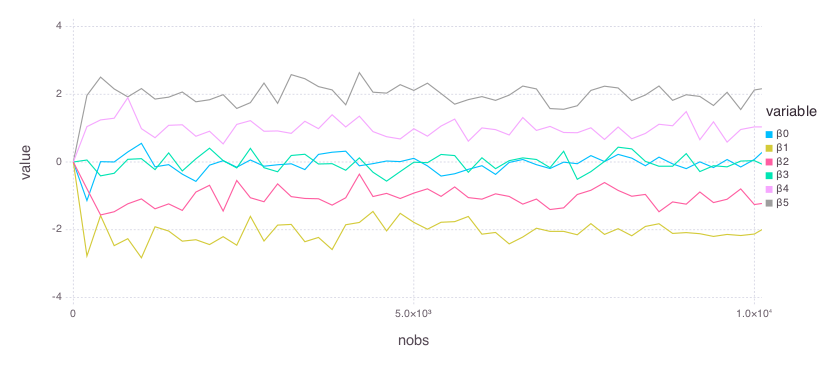

In [9]:
pl = plot(df_melt, x=:nobs, y=:value, color=:variable, Geom.line, Scale.x_continuous(minvalue=0,maxvalue=10_000), Scale.y_continuous(minvalue=-4, maxvalue=4))
draw(PNG(22cm, 10cm), pl)

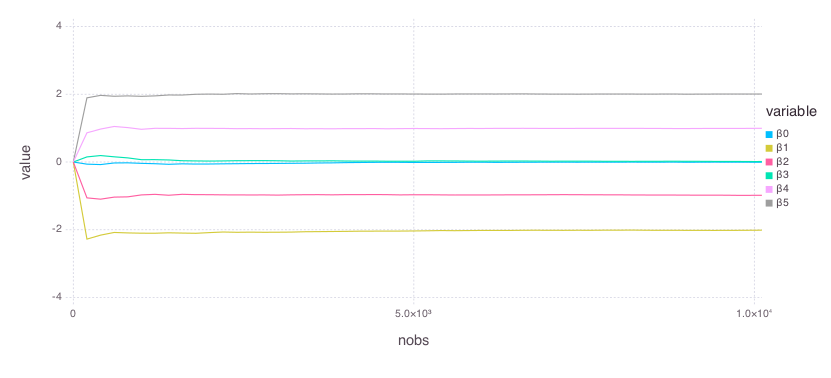

In [10]:
pl = plot(dfm_melt, x=:nobs, y=:value, color=:variable, Geom.line, Scale.x_continuous(minvalue=0,maxvalue=10_000), Scale.y_continuous(minvalue=-4, maxvalue=4))
draw(PNG(22cm, 10cm), pl)